## Sieć neuronowa

$[x_1, x_2] = [a_1^{[1]}, a_2^{[1]}] \mapsto [a_1^{[2]}, a_2^{[2]}] \mapsto [a_1^{[3]}, a_2^{[3]}, a_3^{[3]}] \mapsto [a_1^{[4]}, a_2^{[4]}] = [y_1, y_2] =: F_p(x)$

$a^{[k+1]} = \sigma(W^{[k+1]}a^{[k]} + b^{[k+1]}), k = 1, 2, 3$

Dane trenujące:

$X_0, ..., X_{M-1}$, $M = 10$, $X_k = [x_1^{(k)}, x_2^{(k)}]$

$Y_0, ..., Y_{M-1}$, $Y_k \in \{[1, 0], [0, 1]\}$

Funkcja straty:

$\sum_{i=0}^{M-1} ||F_p(X_i) - Y_i||_2^2 \to \min_{p \in \R^{23}}!$

$W_2 \in \R^{2\times 2}, W_3 \in \R^{3\times 2}, W_4 \in \R^{2\times 3}$

$b_2 \in \R^2, b_3 \in \R^3, b_4 \in \R^2$

In [2]:
from scipy.optimize import least_squares
import numpy as np

In [3]:
x1 = np.array([0.1, 0.3, 0.1, 0.6, 0.4, 0.6, 0.5, 0.9, 0.4, 0.7])
x2 = np.array([0.1, 0.4, 0.5, 0.9, 0.2, 0.3, 0.6, 0.2, 0.4, 0.6])

y1 = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])
y2 = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

X = np.vstack((x1, x2)).T
Y = np.vstack((y1, y2)).T

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
def F(x, p):
    assert x.shape == (2,)
    assert p.shape == (23,)
    
    W2, W3, W4, b2, b3, b4 = p[:4], p[4:10], p[10:16], p[16:18], p[18:21], p[21:23]
    W2 = W2.reshape((2, 2))
    W3 = W3.reshape((3, 2))
    W4 = W4.reshape((2, 3))
    
    assert W2.shape == (2, 2)
    assert W3.shape == (3, 2)
    assert W4.shape == (2, 3)
    assert b2.shape == (2,)
    assert b3.shape == (3,)
    assert b4.shape == (2,)
    
    a1 = x
    a2 = sigmoid(W2 @ a1 + b2)
    a3 = sigmoid(W3 @ a2 + b3)
    a4 = sigmoid(W4 @ a3 + b4)
    y = a4
    
    assert y.shape == (2,)
    
    return y

In [6]:
def f(p, X, Y):
    assert p.shape == (23,)
    
    res = np.array([np.linalg.norm(F(x, p) - y) for x, y in zip(X, Y)])
    return res

f(np.random.randn(23), X, Y)

array([0.60062422, 0.58277105, 0.60201535, 0.56091725, 0.57364508,
       0.90544565, 0.89506016, 0.92651339, 0.88645955, 0.91193764])

In [7]:
p = least_squares(f, np.random.randn(23), args=(X, Y)).x
p

array([-12.6520835 , -10.75490286,  -8.28504338,  10.94294689,
        -6.55754984,  -5.52377957,  14.37617567,  12.43922892,
         0.8807722 ,   0.54810908,  -8.19043786,  17.37672213,
        -0.58798196,   7.17287889, -18.050105  ,   0.42674419,
         8.18545722,  -3.10164463,   3.45652592,  -7.56876441,
         0.66284511,  -4.42281314,   4.67170523])

In [8]:
np.linalg.norm(f(p, X, Y))

0.0001385940277961853

In [9]:
F(X[0,:], p)

array([9.99994916e-01, 2.81564621e-06])

In [22]:
import matplotlib.pyplot as plt

def plot_result(p):
    X1 = np.linspace(0, 1, 100)
    X2 = np.linspace(0, 1, 100)
    X1, X2 = np.meshgrid(X1, X2)

    Y_test_result = np.array([F(np.array([x1, x2]), p) for x1, x2 in zip(X1.flatten(), X2.flatten())])
    Y_test_classification = np.array([y[0] > y[1] for y in Y_test_result])

    plt.figure(figsize=(10, 10))
    plt.scatter(X1, X2, c=Y_test_classification)
    plt.scatter(x1[0:5], x2[0:5], c='red')
    plt.scatter(x1[5:10], x2[5:10], c='blue')

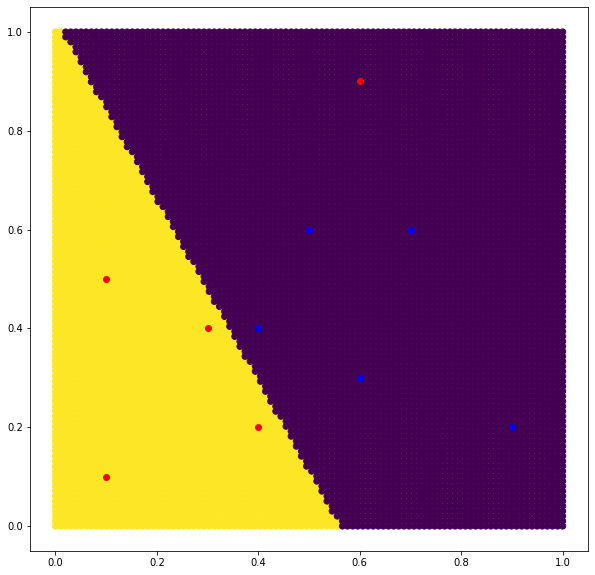

In [23]:
plot_result(p)

## Gradient descent
$p_{k+1} = p_k - \lambda \cdot \nabla \text{cost}(p_i)$

$c_i(p) := ||F_p(X_i) - Y_i||_2^2$

$z_l = W^{[l]}a^{[l-1]} + b^{[l]}$

Na ćwiczeniach obliczyliśmy $\nabla C_i (p)$:

$\delta^{[L]} = \sigma' (z^{[l]}) \cdot (a^{[l]} - y_i)$

$\delta^{[l]} = \sigma' (z^{[l]}) \cdot (W^{[l+1]})^T \cdot \delta^{[l+1]}$

$\frac{\partial C_i}{\partial b_j^{[l]}} = \delta_j^{[l]}$

$\frac{\partial C_i}{\partial W_{j,k}^{[l]}} = \delta_j^{[l]} \cdot a_k^{[l-1]}$

In [24]:
def grad_C(p, x, y):
    assert p.shape == (23,)
    assert x.shape == (2,)
    assert y.shape == (2,)
    
    W2, W3, W4, b2, b3, b4 = p[:4], p[4:10], p[10:16], p[16:18], p[18:21], p[21:23]
    W2 = W2.reshape((2, 2))
    W3 = W3.reshape((3, 2))
    W4 = W4.reshape((2, 3))
    
    assert W2.shape == (2, 2)
    assert W3.shape == (3, 2)
    assert W4.shape == (2, 3)
    assert b2.shape == (2,)
    assert b3.shape == (3,)
    assert b4.shape == (2,)
    
    a1 = x
    z2 = W2 @ a1 + b2
    a2 = sigmoid(z2)
    z3 = W3 @ a2 + b3
    a3 = sigmoid(z3)
    z4 = W4 @ a3 + b4
    a4 = sigmoid(z4)
    
    assert a4.shape == (2,)
    
    delta_4 = sigmoid(z4) * (1 - sigmoid(z4)) * (a4 - y)
    delta_3 = sigmoid(z3) * (1 - sigmoid(z3)) * (W4.T @ delta_4)
    delta_2 = sigmoid(z2) * (1 - sigmoid(z2)) * (W3.T @ delta_3)
    
    assert delta_4.shape == (2,)
    assert delta_3.shape == (3,)
    assert delta_2.shape == (2,)
    
    grad_W2 = delta_2.reshape((2, 1)) @ a1.reshape((1, 2))
    grad_W3 = delta_3.reshape((3, 1)) @ a2.reshape((1, 2))
    grad_W4 = delta_4.reshape((2, 1)) @ a3.reshape((1, 3))
    
    assert grad_W2.shape == (2, 2)
    assert grad_W3.shape == (3, 2)
    assert grad_W4.shape == (2, 3)
    
    grad_b2 = delta_2
    grad_b3 = delta_3
    grad_b4 = delta_4
    
    assert grad_b2.shape == (2,)
    assert grad_b3.shape == (3,)
    assert grad_b4.shape == (2,)
    
    grad = np.concatenate((grad_W2.flatten(), grad_W3.flatten(), grad_W4.flatten(), grad_b2, grad_b3, grad_b4))
    
    assert grad.shape == (23,)
    
    return grad

# Training

In [58]:
p = np.random.randn(23)
learning_rate = 1
epochs = 10000
for epoch in range(epochs):
    for x, y in zip(X, Y):
        p -= learning_rate * grad_C(p, x, y)
F(X[0,:], p)

array([9.99948110e-01, 5.12009556e-05])

In [59]:
np.linalg.norm(f(p, X, Y))

0.017902401186076826

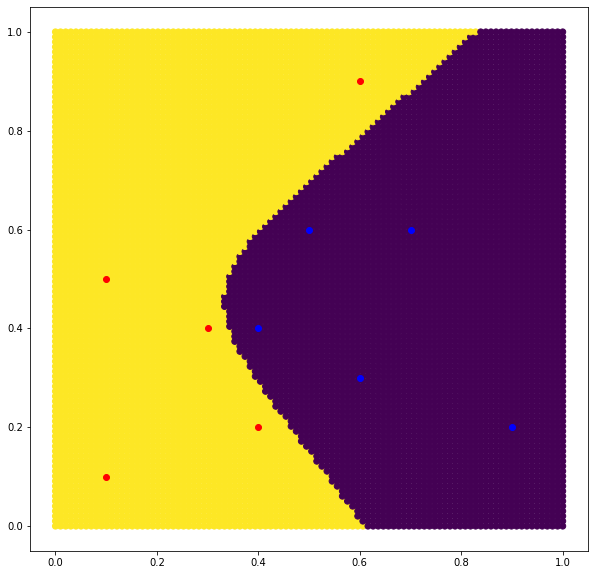

In [60]:
plot_result(p)

In [65]:
p = np.random.randn(23)
learning_rate = 0.05
epochs = 500000
residues = []

for epoch in range(epochs):
    i = np.random.randint(0, len(X))
    x, y = X[i,:], Y[i]
    p -= learning_rate * grad_C(p, x, y)
    if epoch % 20 == 0:
        residues += [np.linalg.norm(f(p, X, Y))]
    
F(X[0,:], p)

array([0.99343827, 0.00637393])

In [66]:
np.linalg.norm(f(p, X, Y))

0.06163809158567005

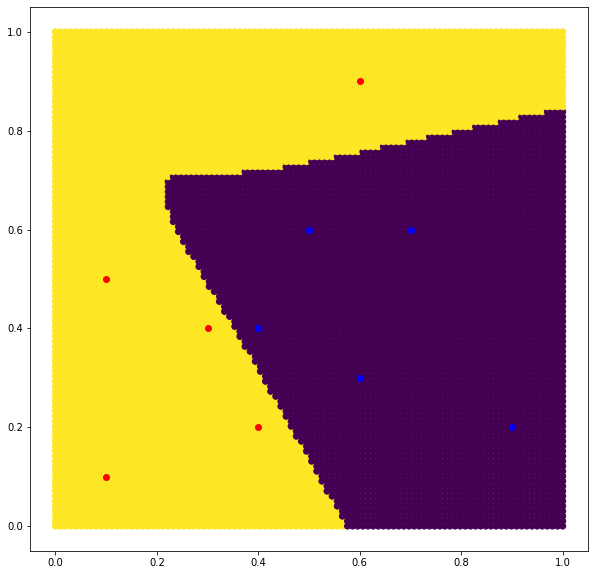

In [67]:
plot_result(p)

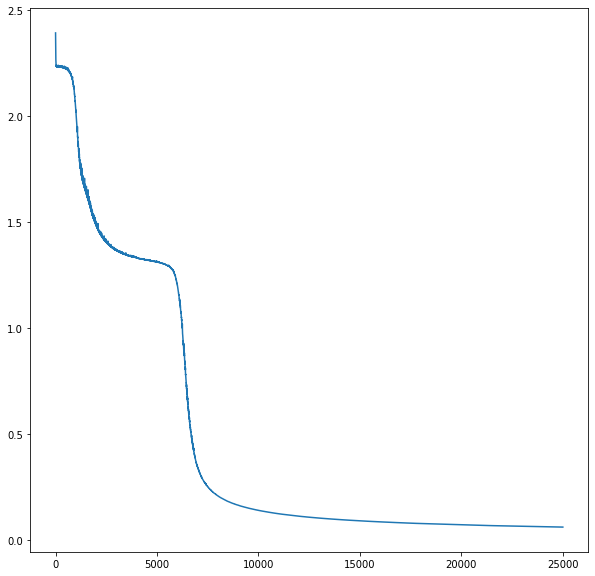

In [74]:
# plot residues
plt.figure(figsize=(10, 10))
plt.plot(residues)